## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk
from sklearn.model_selection import train_test_split
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import conlltags2tree, tree2conlltags

%matplotlib inline

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
nltk_data[:2]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')]]

In [4]:
train_set, test_set = train_test_split(nltk_data,test_size=0.05,random_state=100)

In [5]:
print('Training set length: {}'.format(len(train_set)))
print('Test set length: {}'.format(len(test_set)))

Training set length: 3718
Test set length: 196


In [6]:
tagged_train_words = [tup for sent in train_set for tup in sent]
tagged_train_words[:10]

[('One', 'NUM'),
 ('bright', 'ADJ'),
 ('sign', 'NOUN'),
 ('is', 'VERB'),
 ('that', 'ADP'),
 ('a', 'DET'),
 ('growing', 'VERB'),
 ('number', 'NOUN'),
 ('of', 'ADP'),
 ('women', 'NOUN')]

In [7]:
len(tagged_train_words)

95949

In [8]:
# Getting tokens from the training set
tokens = [word[0] for word in tagged_train_words]
vocab = set(tokens)
print(len(vocab))

12106


In [9]:
tags = set([word[1] for word in tagged_train_words])
len(tags)

12

In [10]:
print(tags)

{'X', 'NUM', '.', 'VERB', 'NOUN', 'PRON', 'PRT', 'ADJ', 'DET', 'ADV', 'ADP', 'CONJ'}


## POS Tagging Algorithm - HMM

#### Transition Probabilities

In [11]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = tagged_train_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [12]:
tags_matrix = np.zeros((len(tags), len(tags)), dtype='float32')
for i, t1 in enumerate(list(tags)):
    for j, t2 in enumerate(list(tags)): 
        t2_given_t1_val = t2_given_t1(t2,t1)
        tags_matrix[i, j] = t2_given_t1_val[0]/t2_given_t1_val[1]

In [13]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(tags), index=list(tags))

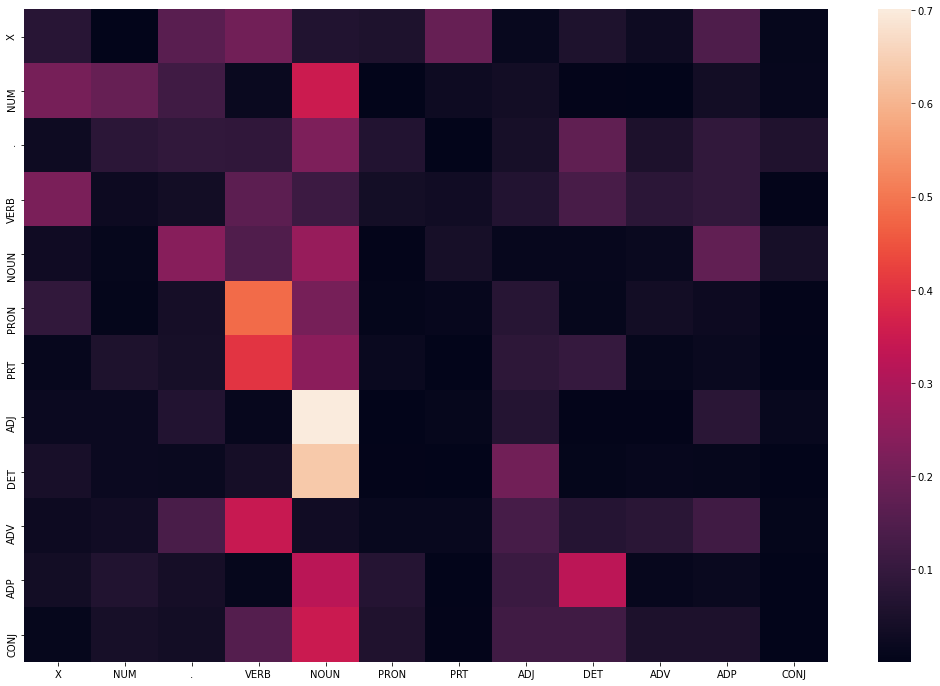

In [14]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

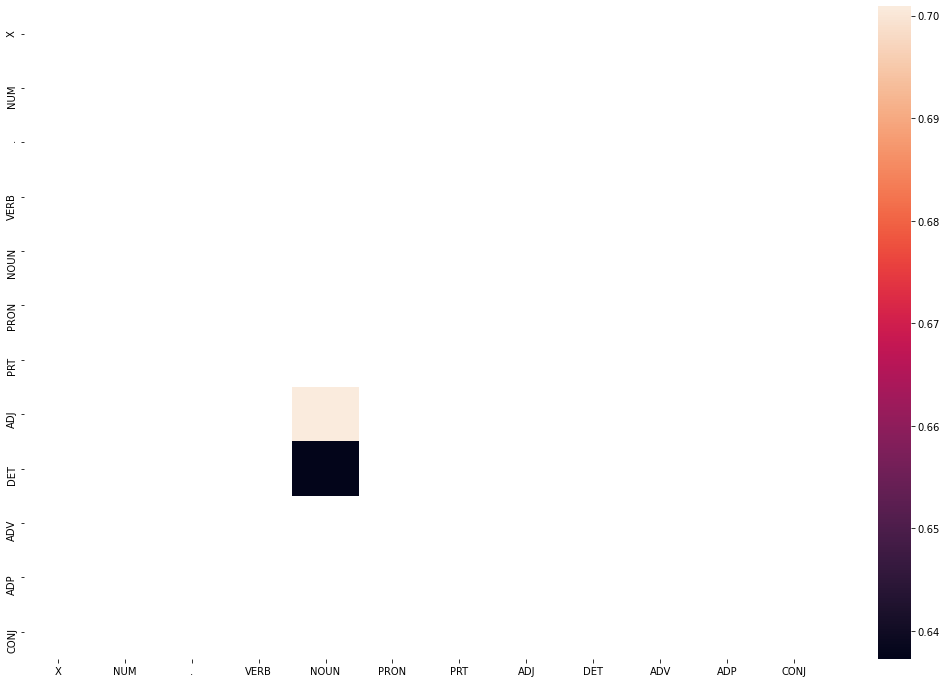

In [15]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

#### Emission Probabilities

In [16]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = tagged_train_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

### Build the vanilla Viterbi based POS tagger

In [17]:
# Viterbi Heuristic
def Viterbi(words, train_bag = tagged_train_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            word_given_tag_val = word_given_tag(words[key], tag)
            emission_p = word_given_tag_val[0]/word_given_tag_val[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [18]:
test_run_base = [tup for sent in test_set for tup in sent]
test_tagged_words = [tup[0] for sent in test_set for tup in sent]
len(test_tagged_words)

4727

In [19]:
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [20]:
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  697.0276987552643
[('Investors', 'NOUN'), ('took', 'VERB'), ('advantage', 'NOUN'), ('of', 'ADP'), ('Tuesday', 'NOUN'), ("'s", 'PRT'), ('stock', 'NOUN'), ('rally', 'NOUN'), ('*-1', 'X'), ('to', 'PRT'), ('book', 'NOUN'), ('some', 'DET'), ('profits', 'NOUN'), ('yesterday', 'NOUN'), (',', '.'), ('*-1', 'X'), ('leaving', 'VERB'), ('stocks', 'NOUN'), ('up', 'PRT'), ('fractionally', 'ADV'), ('.', '.'), ('Buying', 'VERB'), ('for', 'ADP'), ('the', 'DET'), ('most', 'ADJ'), ('part', 'NOUN'), ('carried', 'VERB'), ('over', 'ADP'), ('from', 'ADP'), ('the', 'DET'), ('previous', 'ADJ'), ('session', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('traders', 'NOUN'), ('apparently', 'ADV'), ('ignored', 'X'), ('reports', 'VERB'), ('that', 'ADP'), ('a', 'DET'), ('Chilean', 'ADJ'), ('mine', 'NOUN'), ('strike', 'NOUN'), ('may', 'VERB'), ('have', 'VERB'), ('ended', 'VERB'), ('almost', 'ADV'), ('before', 'ADP'), ('it', 'PRON'), ('began', 'VERB'), (',', '.'), ('an', 'DET'), ('analyst', 'NOUN'), (

In [21]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [22]:
accuracy = len(check)/len(tagged_seq)

In [23]:
accuracy

0.905013750793315

In [24]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [25]:
incorrect_tagged_cases

[[('to', 'PRT'), (('book', 'NOUN'), ('book', 'VERB'))],
 [('leaving', 'VERB'), (('stocks', 'NOUN'), ('stocks', 'ADV'))],
 [('stocks', 'ADV'), (('up', 'PRT'), ('up', 'ADP'))],
 [('carried', 'VERB'), (('over', 'ADP'), ('over', 'PRT'))],
 [('apparently', 'ADV'), (('ignored', 'X'), ('ignored', 'VERB'))],
 [('ignored', 'VERB'), (('reports', 'VERB'), ('reports', 'NOUN'))],
 [('Chilean', 'ADJ'), (('mine', 'NOUN'), ('mine', 'ADJ'))],
 [('the', 'DET'), (('Palestinian', 'ADJ'), ('Palestinian', 'NOUN'))],
 [('committee', 'NOUN'), (('first', 'ADJ'), ('first', 'ADV'))],
 [('.', '.'), (('Preston', 'X'), ('Preston', 'NOUN'))],
 [('Foster', 'NOUN'), (('Birmingham', 'X'), ('Birmingham', 'NOUN'))],
 [(',', '.'), (('Ala', 'X'), ('Ala', 'NOUN'))],
 [('has', 'VERB'), (('clamped', 'X'), ('clamped', 'VERB'))],
 [('their', 'PRON'), (('ankle', 'X'), ('ankle', 'NOUN'))],
 [('the', 'DET'), (('third-largest', 'X'), ('third-largest', 'ADJ'))],
 [('the', 'DET'), (('fifth-largest', 'X'), ('fifth-largest', 'ADJ'))],


In [26]:
## Testing
sentence_test = 'Android is a mobile operating system developed by Google.'
words = nltk.word_tokenize(sentence_test)

start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start

In [27]:
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  1.4894318580627441
[('Android', 'X'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'X'), ('.', '.')]


### Solve the problem of unknown words

### We will use two types of models:
1. Unigram, Bigram and Trigram Models
2. Conditional Random Fields(CRFs)

In [28]:
# Lexicon (or unigram tagger)
unigram_tagger = nltk.UnigramTagger(train_set)
accuracy_unigram_tagger = unigram_tagger.evaluate(test_set)
print(accuracy_unigram_tagger)

0.9014173894647768


In [29]:
# specify patterns for tagging
# example from the NLTK book
patterns = [
    (r'.*ing$', 'VBG'),              # gerund
    (r'.*ed$', 'VBD'),               # past tense
    (r'.*es$', 'VBZ'),               # 3rd singular present
    (r'.*ould$', 'MD'),              # modals
    (r'.*\'s$', 'NN$'),              # possessive nouns
    (r'.*s$', 'NNS'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'CD'), # cardinal numbers
    (r'.*', 'NN')                    # nouns
]

In [30]:
# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

# lexicon backed up by the rule-based tagger
lexicon_tagger = nltk.UnigramTagger(train_set, backoff=rule_based_tagger)

accuracy_lexicon_tagger = lexicon_tagger.evaluate(test_set)
print(accuracy_lexicon_tagger)

0.9014173894647768


In [31]:
# Bigram and Trigram tagger
bigram_tagger = nltk.BigramTagger(train_set,backoff=lexicon_tagger)
bigram_tagger.evaluate(test_set)
accuracy_bigram_tagger = bigram_tagger.evaluate(test_set)
print(accuracy_bigram_tagger)

0.9054368521260842


In [32]:
trigram_tagger = nltk.TrigramTagger(train_set, backoff=bigram_tagger)
trigram_tagger.evaluate(test_set)
accuracy_trigram_tagger = trigram_tagger.evaluate(test_set)
print(accuracy_trigram_tagger)

0.9064946054580072


In [33]:
def trigram_tagger(word,train_set = train_set):
    custom_patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense
    (r'.*es$', 'VERB'),               # 3rd singular present
    (r'.*ould$', 'X'),              # modals
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'.*', 'NOUN')                    # nouns
    ]
    regex_based_tagger = nltk.RegexpTagger(custom_patterns)

    # trigram backed up by the regex tagger
    trigram_regex_tagger = nltk.TrigramTagger(train_set, backoff=regex_based_tagger)
    return trigram_regex_tagger.tag_sents([[(word)]])

In [34]:
# viterbi with handling for unknown words from regex tagger

def Viterbi_modified(words, train_bag = tagged_train_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        # unknown words from trigram taggr
        if word not in tokens:
            unk_word_tag=trigram_tagger(word)
            for sent in unk_word_tag:
                for tup in sent:
                    state.append(tup[1])
        # rest remains same            
        else:            
            p = [] 
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
            
    return list(zip(words, state))

#### Evaluating tagging accuracy

In [35]:
start = time.time()
tagged_seq = Viterbi_modified(test_tagged_words)
end = time.time()
difference = end-start

In [36]:
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  1806.8177659511566
[('Investors', 'NOUN'), ('took', 'VERB'), ('advantage', 'NOUN'), ('of', 'ADP'), ('Tuesday', 'NOUN'), ("'s", 'PRT'), ('stock', 'NOUN'), ('rally', 'NOUN'), ('*-1', 'X'), ('to', 'PRT'), ('book', 'NOUN'), ('some', 'DET'), ('profits', 'NOUN'), ('yesterday', 'NOUN'), (',', '.'), ('*-1', 'X'), ('leaving', 'VERB'), ('stocks', 'NOUN'), ('up', 'PRT'), ('fractionally', 'ADV'), ('.', '.'), ('Buying', 'VERB'), ('for', 'ADP'), ('the', 'DET'), ('most', 'ADJ'), ('part', 'NOUN'), ('carried', 'VERB'), ('over', 'ADP'), ('from', 'ADP'), ('the', 'DET'), ('previous', 'ADJ'), ('session', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('traders', 'NOUN'), ('apparently', 'ADV'), ('ignored', 'VERB'), ('reports', 'NOUN'), ('that', 'ADP'), ('a', 'DET'), ('Chilean', 'ADJ'), ('mine', 'NOUN'), ('strike', 'NOUN'), ('may', 'VERB'), ('have', 'VERB'), ('ended', 'VERB'), ('almost', 'ADV'), ('before', 'ADP'), ('it', 'PRON'), ('began', 'VERB'), (',', '.'), ('an', 'DET'), ('analyst', 'NOUN'

In [37]:
# accuracy
check1 = [i for i, j in zip(tagged_seq, test_run_base) if i == j]
accuracy_viterbi_modified = len(check1)/len(tagged_seq)
accuracy_viterbi_modified

0.946689232071081

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [38]:
print(accuracy_lexicon_tagger)

0.9014173894647768


In [39]:
print(accuracy_unigram_tagger)

0.9014173894647768


In [40]:
print(accuracy_bigram_tagger)

0.9054368521260842


In [41]:
print(accuracy_trigram_tagger)

0.9064946054580072


In [42]:
print(accuracy_viterbi_modified)

0.946689232071081


### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [43]:
## Testing
sentence_test1 = 'Google and Twitter made a deal in 2015 that gave Google access to Twitter\'s firehose.'
words = nltk.word_tokenize(sentence_test1)
tagged_seq = Viterbi(words)
print(tagged_seq)

[('Google', 'X'), ('and', 'CONJ'), ('Twitter', 'X'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'X'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'X'), ("'s", 'PRT'), ('firehose', 'X'), ('.', '.')]


In [44]:
tagged_seq_modified = Viterbi_modified(words)
print(tagged_seq_modified)

[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')]


In [45]:
sentence_test2='Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'
words = nltk.word_tokenize(sentence_test2)
tagged_seq = Viterbi(words)
print(tagged_seq)

[('Android', 'X'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'X'), ('worldwide', 'X'), ('on', 'ADP'), ('smartphones', 'X'), ('since', 'ADP'), ('2011', 'X'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'X'), ('.', '.')]


In [46]:
tagged_seq_modified = Viterbi_modified(words)
print(tagged_seq_modified)

[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]


In [47]:
sentence_test3='I Instagrammed a Facebook post taken from Android smartphone and uploaded results to Youtube.'
words = nltk.word_tokenize(sentence_test3)
tagged_seq = Viterbi(words)
print(tagged_seq)

[('I', 'PRON'), ('Instagrammed', 'X'), ('a', 'DET'), ('Facebook', 'X'), ('post', 'VERB'), ('taken', 'VERB'), ('from', 'ADP'), ('Android', 'X'), ('smartphone', 'X'), ('and', 'CONJ'), ('uploaded', 'X'), ('results', 'NOUN'), ('to', 'PRT'), ('Youtube', 'X'), ('.', '.')]


In [48]:
tagged_seq_modified = Viterbi_modified(words)
print(tagged_seq_modified)

[('I', 'PRON'), ('Instagrammed', 'VERB'), ('a', 'DET'), ('Facebook', 'NOUN'), ('post', 'NOUN'), ('taken', 'VERB'), ('from', 'ADP'), ('Android', 'NOUN'), ('smartphone', 'NOUN'), ('and', 'CONJ'), ('uploaded', 'VERB'), ('results', 'NOUN'), ('to', 'PRT'), ('Youtube', 'NOUN'), ('.', '.')]


We see the new words - Youtube, Facebook, smartphone going from X to NOUN. We alse see the verb of Instagrammed,uploaded getting recognised correctly